In this notebook we take the Illustris-1 simulation volume to find Local Group candidates.

Usually these candidates are found using the dark matter information. 
In this notebook we take a different approach by selecting them based on the baryonic information.

Our candidates are thus pairs selected based on the stellar masses.

1. They are composed by two galaxies $G_A$ and $G_B$.
2. $G_A$ and $G_B$ belong to the set of dark matter halos $S_{1}$; $S_{1}$ contains all subhalos with stellar mass content  $1.0\times 10^{10}$ M$_{\odot}<M_s < 1.0\times 10^{11}$ M$_{\odot}$ (http://adsabs.harvard.edu//abs/2013AAS...22125411L, http://arxiv.org/abs/1410.0017)
3. The distance between $H_A$ and $H_B$ is less than 1.5 Mpc.
4. $H_A$ and $H_B$ are mutually its nearest halos in the set $S_{1}$.
5. There are not any subhalos with vmax larger than min(200km/s, Vmax $H_A$, Vmax $H_B$) within $5 \mathrm{Mpc}$ of either $H_A$ or $H_B$.

We now proceed to build such sample.

In [1]:
%pylab inline
import illustris_python.groupcat as gc
from sklearn.neighbors import NearestNeighbors

Populating the interactive namespace from numpy and matplotlib


In [2]:
basePath = "/hpcfs/home/ciencias/fisica/docentes/je.forero/Illustris-1/"

In [3]:
#halos = gc.loadHalos(basePath,135)
#subhalos = gc.loadSubhalos(basePath,135)
#header = gc.loadHeader(basePath,135)
#BoxSize = header['BoxSize']

halo_fields = ['GroupFirstSub', 'Group_M_Crit200', 'Group_R_Crit200', 'Group_M_Mean200',
               'GroupNsubs', 'GroupPos', 'GroupVel', 'GroupFirstSub', 'GroupMassType']
halos = gc.loadHalos(basePath,135, fields=halo_fields) # the selection is based on the FOF groups

subhalo_fields = ['SubhaloMass','SubhaloSFRinRad', 'SubhaloPos', 'SubhaloVmax','SubhaloMassType',
                  'SubhaloVel', 'SubhaloParent', 'SubhaloGrNr', 'SubhaloStellarPhotometrics']
subhalos = gc.loadSubhalos(basePath,135, fields=subhalo_fields)
header = gc.loadHeader(basePath,135)
BoxSize = header['BoxSize']

In [4]:
print(halos.keys())
print(subhalos.keys())

dict_keys(['GroupNsubs', 'Group_M_Mean200', 'GroupVel', 'GroupPos', 'Group_R_Crit200', 'GroupFirstSub', 'Group_M_Crit200', 'GroupMassType', 'count'])
dict_keys(['SubhaloVel', 'SubhaloVmax', 'SubhaloPos', 'SubhaloSFRinRad', 'SubhaloMassType', 'SubhaloParent', 'count', 'SubhaloStellarPhotometrics', 'SubhaloGrNr', 'SubhaloMass'])


In [6]:
#mases are: Gas, DM, unused, tracers, stars+wind particles, black holes
halo_masses = halos['GroupMassType']
subhalo_masses = subhalos['SubhaloMassType']
halo_M_crit200 = halos['Group_M_Mean200']
subhalo_pos = subhalos['SubhaloPos']
subhalo_stellar_mass = subhalo_masses[:,4]
subhalo_mags = subhalos['SubhaloStellarPhotometrics']
subhalo_vmax = subhalos['SubhaloVmax']
print(shape(subhalo_vmax))

(4366546,)


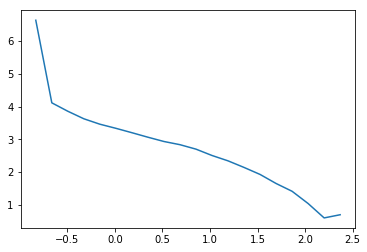

In [7]:
vals, edges = histogram(log10(subhalo_stellar_mass+1E-1), bins=20)
plot(edges[1:], log10(vals))

In [12]:
#selects the indices for two sets:
# 1. MW like
# 2. massive galaxies above 1.2E11 Msun in stars
# 3. MW like + massive galaxies above 1.2E11 Msun in stars

index_S1 = where((subhalo_stellar_mass>1.0) & (subhalo_stellar_mass<10.0))
index_S2 = where(subhalo_stellar_mass>10.0)
index_S3 = where(subhalo_stellar_mass>1.0)
n_S1 = size(index_S1)
n_S2 = size(index_S2)
n_S3 = size(index_S3)
print("size set S1: %d halos"%(n_S1))
print("size set S2: %d halos"%(n_S2))
print("size set S3: %d halos"%(n_S3))

size set S1: 4778 halos
size set S2: 565 halos
size set S3: 5343 halos


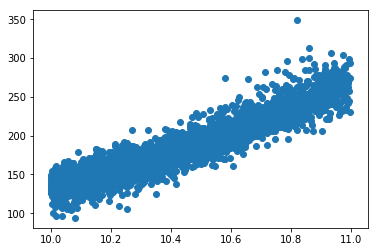

In [13]:
scatter(log10(subhalo_stellar_mass[index_S1])+10, subhalo_vmax[index_S1])

In [14]:
S3_pos = subhalos['SubhaloPos'][index_S3]
S3_vel = subhalos['SubhaloVel'][index_S3]
S3_vmax = subhalos['SubhaloVmax'][index_S3]
S3_stellar_mass = subhalo_stellar_mass[index_S3]
#https://github.com/forero/IllustrisLG/blob/master/code/LocalGroupSubVolumes.ipynb

In [15]:
#pad boxes around the S3 positions to mimic periodic boundary conditions
S3_pad_pos = S3_pos.copy()
S3_pad_vel = S3_vel.copy()
S3_pad_vmax = S3_vmax.copy()
S3_pad_stellar_mass = S3_stellar_mass.copy()
S3_pad_id = arange(n_S3)
for i in (0,1,-1):
    for j in (0,1,-1):
        for k in (0,1,-1):
            new_pos = S3_pos.copy()
            if(i):
                new_pos[:,0] = new_pos[:,0] + i*BoxSize
            if(j):
                new_pos[:,1] = new_pos[:,1] + j*BoxSize
            if(k):
                new_pos[:,2] = new_pos[:,2] + k*BoxSize
                
            if((i!=0) | (j!=0) | (k!=0)):
                S3_pad_pos = append(S3_pad_pos, new_pos, axis=0)
                S3_pad_vel = append(S3_pad_vel, S3_vel, axis=0)
                S3_pad_vmax = append(S3_pad_vmax, S3_vmax)
                S3_pad_stellar_mass = append(S3_pad_stellar_mass, S3_stellar_mass)
                S3_pad_ID = append(S3_pad_id, arange(n_S3))

In [17]:
nbrs_S3 = NearestNeighbors(n_neighbors=20, algorithm='ball_tree').fit(S3_pad_pos)
dist_S3, ind_S3 = nbrs_S3.kneighbors(S3_pad_pos)
print(S3_pad_pos.shape)
print(dist_S3.shape)

(144261, 3)
(144261, 20)


In [67]:
neighbor_index = ind_S3[:,1]
neighbor_list = ind_S3[:,2:]
print(shape(neighbor_list))

n_pairs = 0

halo_A_id = empty((0), dtype=int)
halo_B_id = empty((0), dtype=int)

for i in range(n_S3):
    l = neighbor_index[neighbor_index[i]]% n_S3
    j = neighbor_index[i] % n_S3
    
    other_j = neighbor_list[i,:] % n_S3
    other_l = neighbor_list[neighbor_index[i],:] % n_S3
    
    if((i==l) & (not (j in halo_A_id)) & (not (j in halo_B_id))): # first check to find mutual neighbors
        
        if((S3_stellar_mass[i]<10.0) & (S3_stellar_mass[j]<10.0)): #second check on the masses of the two galaxies
            if((dist_S3[i,1]<(1500.0)) & (dist_S3[i,1]>500.0)): #third check on the distance between the two halos
                stellar_mass_i = S3_pad_stellar_mass[i]
                stellar_mass_j = S3_pad_stellar_mass[j]
                star_mass_limit = min([stellar_mass_i, stellar_mass_j])
                massive_close_to_i = any((dist_S3[i,2:]<(3500.0)) & (S3_pad_stellar_mass[other_j]>=star_mass_limit))
                massive_close_to_j = any((dist_S3[j,2:]<(3500.0)) & (S3_pad_stellar_mass[other_l]>=star_mass_limit))
                if((not massive_close_to_i) & (not massive_close_to_j)): #third check on isolation from massive halos
                    n_pairs = n_pairs+ 1
                    halo_A_id = append(halo_A_id, int(i))
                    halo_B_id = append(halo_B_id, int(j))
print(n_pairs)


(144261, 18)
50


In [68]:
print(dist_S3[halo_A_id,1])
print(neighbor_index[halo_A_id])
print(n_S3)

[  586.06565978   964.53853441   753.05324044  1338.10222993   975.51474838
   671.01306577   906.49344398   974.1696834    692.68791499  1164.39791083
   807.66674222  1160.66288751   837.31543666  1020.03801316  1316.14019678
   928.14368078   720.5340792    692.01105793   594.19980497  1237.71785499
  1422.47650684  1305.70656485  1117.82841072  1286.98047609  1210.81585817
  1081.18907275  1387.11759238   686.91687401   765.3278456   1290.39712149
   948.82016808  1326.22225047   818.91537438  1339.90413456   948.00459464
   587.40512191  1226.55383976   821.81948322  1493.69146597  1265.62882921
  1130.51253456  1402.1333895   1391.89244734   535.67241326   652.52279936
  1395.21485516  1320.50929213   970.38297032   627.22338373  1499.94223504]
[ 2094  3247  2910  3294  3521  3630  3099  3187  4285  2740  4595  3218
  3098  3210  3015  4723  4728  4917 19771  2962  4040  3350  4328  4664
  3198  3564  3715  4291  4571  4543  4778  4667  3314  3736  3391  3861
  3625  4855  4018  

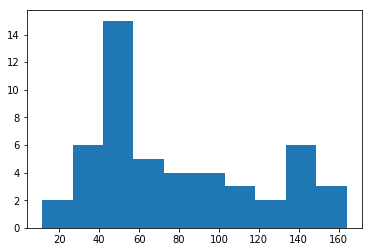

In [69]:
relative_vel = S3_pad_vel[halo_A_id,:] - S3_pad_vel[neighbor_index[halo_A_id], :]
norm_relative_vel = sqrt((relative_vel**2).sum(1))
a = hist(norm_relative_vel)

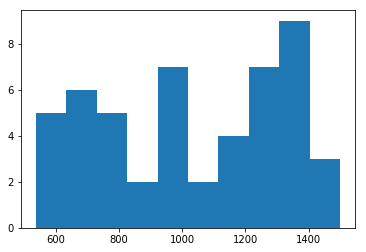

In [70]:
relative_pos = S3_pad_pos[halo_A_id,:] - S3_pad_pos[neighbor_index[halo_A_id], :]
norm_relative_pos = sqrt((relative_pos**2).sum(1))
a = hist(norm_relative_pos)

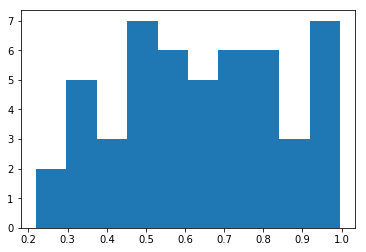

In [71]:
mass_ratio = S3_pad_stellar_mass[halo_A_id]/S3_pad_stellar_mass[neighbor_index[halo_A_id]]
index = where(mass_ratio>1.0)
mass_ratio[index] = 1.0/mass_ratio[index]
a = hist(mass_ratio)

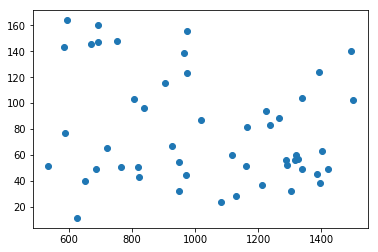

In [72]:
scatter(norm_relative_pos, norm_relative_vel)

# Sub-volume selection

In [73]:
geometric_center = 0.5*(S3_pad_pos[halo_A_id,:] + S3_pad_pos[neighbor_index[halo_A_id],:])

In [74]:
def dump_subvolume(sh, id_list, offset, boxsize, file_id=1, base_filename="test", out_dir="../data/"):
    filename = "%s/%s_%d.dat"%(out_dir, base_filename, file_id)
    out =  open(filename, "w")
    n_points = size(id_list)
    tmp_pos = subhalos['SubhaloPos']
    tmp_mags = subhalos['SubhaloStellarPhotometrics']
    tmp_vel = subhalos['SubhaloVel']
    tmp_vmax = subhalos['SubhaloVmax']
    out.write("#subID\t x\t y\t z\t vx\t yv\t yz\t vmax\t B_MAG V_MAG\n")
    out.write("#subID\t kpc\t kpc\t kpc\t km/s\t km/s\t km/s\t km/s\t mags\n")
    for i in range(n_points):
        ii = id_list[i]
        out.write("%d %f %f %f %f %f %f %f %e %e\n"%(ii, tmp_pos[ii,0], tmp_pos[ii,1], tmp_pos[ii,2], 
                                       tmp_vel[ii,0], tmp_vel[ii,1], tmp_vel[ii,2],
                                       tmp_vmax[ii], subhalo_mags[ii,1], subhalo_mags[ii,2]))

In [76]:
n_subs = size(subhalo_vmax)
print(n_subs)
for i in range(n_pairs):
    center = geometric_center[i,:]%BoxSize
   
    delta = subhalo_pos.copy()
    delta[:,0] = (delta[:,0] - center[0] + BoxSize/2.0)
    delta[:,1] = (delta[:,1] - center[1] + BoxSize/2.0)
    delta[:,2] = (delta[:,2] - center[2] + BoxSize/2.0)
    delta = delta%BoxSize
    
    norm_delta = sqrt(((delta - BoxSize/2.0)**2).sum(1))
    inside = where(norm_delta<3000.0)
    inside = inside[0]
    dump_subvolume(subhalos, inside, (center-BoxSize/2.0), BoxSize, file_id=i, base_filename="Illustris_group", out_dir="../data/mstar_selected/")
    print(size(inside))

4366546
2202
1967
1724
1525
2578
1899
2409
2803
1460
2000
1354
2053
1455
1535
1382
1304
1363
1653
2289
1633
1189
1531
1439
1642
1415
1488
1371
1788
1243
1924
761
1753
1880
1836
1424
1002
1755
1310
2198
1349
1248
1593
2243
961
1135
1024
1262
1580
1509
1320


In [77]:
for i in arange(50):
    data = loadtxt("../data/mstar_selected/Illustris_group_%d.dat"%(i))
    vmax = data[:,7]
    vmax.sort()
    print(i, vmax[-3:])

0 [ 145.491425  207.440659  235.117157]
1 [ 195.129425  208.009125  238.60228 ]
2 [ 159.589401  195.777115  213.110107]
3 [ 123.232185  205.784012  209.181351]
4 [ 136.108643  193.96608   246.36528 ]
5 [ 151.855957  165.017914  219.047989]
6 [ 201.53038   230.848282  243.45047 ]
7 [ 169.610306  199.008057  232.845367]
8 [ 150.696472  190.419693  213.00856 ]
9 [ 166.146484  194.110703  215.722794]
10 [ 121.341209  176.170227  223.329086]
11 [ 144.711716  200.501709  217.045868]
12 [ 168.709778  230.900787  240.52977 ]
13 [ 129.037292  194.787537  223.43602 ]
14 [ 171.545258  196.953461  207.063828]
15 [ 110.151093  188.909134  225.327545]
16 [ 120.299423  146.742325  239.306488]
17 [ 134.885605  155.036163  197.228455]
18 [ 149.709885  177.749603  209.792328]
19 [ 104.337395  186.345688  231.9198  ]
20 [ 136.005524  158.602737  226.151001]
21 [ 141.399567  195.182144  211.796692]
22 [ 138.208145  180.691147  195.595032]
23 [ 141.496719  154.535645  219.776016]
24 [ 141.267624  169.73712

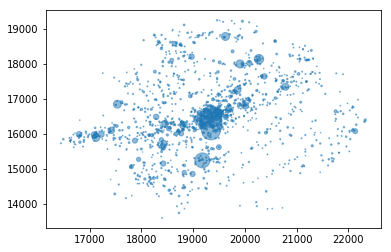

In [94]:
data = loadtxt("../data/mstar_selected/Illustris_group_8.dat")
scatter(data[:,2], data[:,1], s=data[:,7]**2/100, alpha=0.5)